# Задача 4
Решить краевую задачу методами пристрелки и квазилинеаризации:\
$
\begin{cases}
    (y'')^2 + e^{y'}y - \dfrac{e}{\ln x}y^2 = \dfrac{1}{x^2}\\
    y(e) = e \\
    y(e^2) = 2 e^2
\end{cases}
$

## 1. Метод пристрелки

1. Сводим исходную задачу к задаче Коши:\
Переобозначим $x \rightarrow t; y \rightarrow x$\:\
$
\begin{cases}
    (x'')^2 + e^{x'}x - \dfrac{e}{\ln t}x^2 = \dfrac{1}{t^2}\\
    x(e) = e \\
    x(e^2) = 2 e^2
\end{cases}
$\
Пусть $y= x'$, $x'(e) = \alpha$, тогда \
$
\begin{cases}
    x' = y = f(t, x, y) \\
    y' = \left(-e^{y}x + \dfrac{e}{\ln t}x^2 + \dfrac{1}{t^2} \right)^{1/2} = g(t, x, y) \\
    x(e) = e \\
    y(e) = \alpha
\end{cases}
$
2. Решаем систему методом Рунге-Кутты (классическая схема 4 порядка).  Подбор параметра $\alpha$ производим методом половинного деления

In [1]:
from math import sqrt, exp, log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def f(t, x, y):
    return y

def g(t, x, y):
    return sqrt(-exp(y) * x + exp(1) * x ** 2 / log(t) + 1 / t ** 2)

In [3]:
def ODE(t_grid, tau, x_0, y_0, t_check):
    x_n = x_0
    y_n = y_0
    x_check = []
    y_check = []
    i_check = 0
    for i in range(len(t_grid) - 1):
        k1 = f(t_grid[i], x_n, y_n)
        m1 = g(t_grid[i], x_n, y_n)
        k2 = f(t_grid[i] + tau / 2, x_n + tau / 2 * k1, y_n + tau / 2 * m1)
        m2 = g(t_grid[i] + tau / 2, x_n + tau / 2 * k1, y_n + tau / 2 * m1)
        k3 = f(t_grid[i] + tau / 2, x_n + tau / 2 * k2, y_n + tau / 2 * m2)
        m3 = g(t_grid[i] + tau / 2, x_n + tau / 2 * k2, y_n + tau / 2 * m2)
        k4 = f(t_grid[i] + tau, x_n + tau * k3, y_n + tau * m3)
        m4 = g(t_grid[i] + tau, x_n + tau * k3, y_n + tau * m3)
        x_n = x_n + tau / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        y_n = y_n + tau / 6 * (m1 + 2 * m2 + 2 * m3 + m4)

        if abs(t_grid[i] - t_check[i_check]) < 1e-10:
            x_check.append(x_n)
            y_check.append(y_n)
            i_check += 1
    return x_n, y_n, x_check, y_check

In [4]:
t_start = exp(1)
t_end = exp(2)
x_0 = exp(1)
x_1_target = 2 * exp(2)

N = 10 ** 5 + 1
t_grid, tau = np.linspace(t_start, t_end, N, retstep=True)
t_check = t_grid[::1000]

alpha_min = 1
alpha_max = 2
x_end_min, y_end_min, _, _ = ODE(t_grid, tau, x_0, alpha_min, t_check)
x_end_max, y_end_max, x_check, _ = ODE(t_grid, tau, x_0, alpha_max, t_check)
print()
print(f"x_target = {x_1_target}")
print(x_end_min, abs(x_end_min - x_1_target))
print(x_end_max, abs(x_end_max - x_1_target))


x_target = 14.7781121978613
14.439178179083623 0.33893401877767815
14.778112197861281 1.9539925233402755e-14


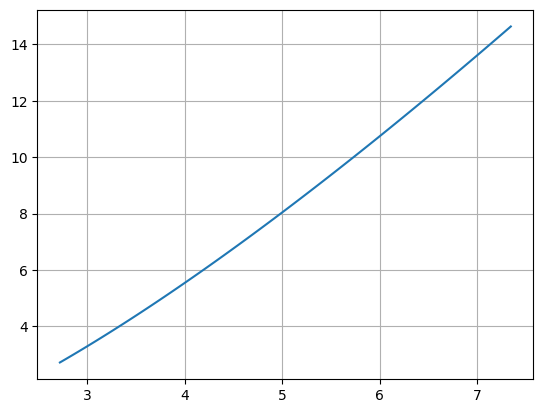

In [5]:
plt.plot(t_check[:len(x_check)], x_check)
plt.grid()

In [6]:
# точки для вывода функции
t_check_base = [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]
i_check_base = 0
t_check_base_i = []
x_check_base_i = []
for i in range(len(t_check)):
    if t_check_base[i_check_base] < t_check[i]:
        t_check_base_i.append(t_check[i])
        x_check_base_i.append(x_check[i])
        i_check_base += 1
    if i_check_base == len(t_check_base):
        break

x_check_method_1 = [i for i in t_check_base_i]
y_check_method_1 = [i for i in x_check_base_i]
pd.DataFrame({"t (исходно x)": x_check_method_1, "x (исходно y)": y_check_method_1})

,t (исходно x),x (исходно y)
0,3.045236,3.391208
1,3.512313,4.412537
2,4.026099,5.607653
3,4.539884,6.868514
4,5.006961,8.065481
5,5.520746,9.432394
6,6.034532,10.847190
7,6.501609,12.171469
8,7.015394,13.666875


## 2. Метод квазилинеаризации

In [7]:
from math import sqrt, exp, log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# метод прогонки (tridiagonal matrix algorithm)
def TMA(a_arr, b_arr, c_arr, d_arr):
    N_pr = len(a_arr)
    p_arr = [0] * N_pr
    q_arr = [0] * N_pr
    x_arr = [0] * N_pr

    # i = 0
    p_arr[1] = -c_arr[0] / b_arr[0]
    q_arr[1] = d_arr[0] / b_arr[0]

    # i = 1, ..., N - 1
    for i in range(2, N_pr, 1):
        p_arr[i] = -c_arr[i - 1] / (a_arr[i - 1] * p_arr[i - 1] + b_arr[i - 1])
        q_arr[i] = (d_arr[i - 1] - a_arr[i - 1] * q_arr[i - 1]) / (a_arr[i - 1] * p_arr[i - 1] + b_arr[i - 1])

    x_arr[N_pr - 1] = (d_arr[N_pr - 1] - a_arr[N_pr - 1] * q_arr[N_pr - 1]) / (p_arr[N_pr - 1] * a_arr[N_pr - 1] + b_arr[N_pr - 1])
    
    # обратный ход
    for i in range(N_pr - 2, -1, -1):
        x_arr[i] = x_arr[i + 1] * p_arr[i + 1] + q_arr[i + 1]
    
    return x_arr


# начальное приближение
def y_0(x):
    return x * log(x)

def y_0_vec(x_arr):
    N = len(x_arr)
    ret = [0] * N
    for i in range(N):
        ret[i] = y_0(x_arr[i])
    return ret


# численные производные приближения
# первая производная
def y_der1(tau, y_n, y_n1):
    # y_n == y(n); y_n1 == y(n+1) 
    return (y_n1 - y_n) / tau

# вторая производная
def y_der2(tau, y_n_1, y_n, y_n1):
    # y_n_1 == y(n-1); y_n == y(n); y_n1 == y(n+1) 
    return (y_n1 - 2 * y_n + y_n_1) / tau ** 2


# векторы производных начального приближения
def y_der1_vec(tau, y_arr):
    N = len(y_arr)
    ret = [None] * N
    for i in range(N - 1):
        ret[i] = y_der1(tau, y_arr[i], y_arr[i + 1])
    return ret

def y_der2_vec(tau, y_arr):
    N = len(y_arr)
    ret = [None] * N
    for i in range(1, N - 1, 1):
        ret[i] = y_der2(tau, y_arr[i - 1], y_arr[i], y_arr[i + 1])
    return ret


# функции (коэффициенты в уравнении)
def g(x, y, y_der1, y_der2):
    # x - точка
    # y - начальное приближение в точке x
    # y_der1 - производная начального приближения в точке x
    # y_der2 - вторая производная начального приближения в точке x
    return y * exp(y_der1) / 2 / y_der2

def h(x, y, y_der1, y_der2):
    return (exp(y_der1) - 2 * y * exp(1) / log(x)) / 2 / y_der2

def f(x, y, y_der1, y_der2):
    return (1 / x ** 2 - y_der2 ** 2 - exp(y_der1) * y + y ** 2 * exp(1) / log(x)) / 2 / y_der2


# вектор-функции (коэффициенты в уравнении)
def g_vec(x_arr, y_arr, y_der1_arr, y_der2_arr):
    N = len(x_arr)
    ret = [None] * N
    for i in range(1, N - 1, 1):
        ret[i] = g(x_arr[i], y_arr[i], y_der1_arr[i], y_der2_arr[i])
    return ret

def h_vec(x_arr, y_arr, y_der1_arr, y_der2_arr):
    N = len(x_arr)
    ret = [None] * N
    for i in range(1, N - 1, 1):
        ret[i] = h(x_arr[i], y_arr[i], y_der1_arr[i], y_der2_arr[i])
    return ret

def f_vec(x_arr, y_arr, y_der1_arr, y_der2_arr):
    N = len(x_arr)
    ret = [None] * N
    for i in range(1, N - 1, 1):
        ret[i] = f(x_arr[i], y_arr[i], y_der1_arr[i], y_der2_arr[i])
    return ret


# коэффициенты для матрицы из метода прогонки
def a_n(tau, g_n, h_n, f_n):
    return 1 + tau * g_n

def b_n(tau, g_n, h_n, f_n):
    return -2 - tau * g_n + tau ** 2 * h_n

def c_n(tau, g_n, h_n, f_n):
    return 1

def d_n(tau, g_n, h_n, f_n):
    return tau ** 2 * f_n


# векторы коэффициентов для матрицы из метода прогонки
def a_n_vec(tau, g_n_arr, h_n_arr, f_n_arr):
    # a(0) = a(N) = 0, a(n) при n = 1, ..., N-1 вычисляются
    N = len(g_n_arr)
    ret = [0] * N
    for i in range(1, N - 1, 1):
        ret[i] = a_n(tau, g_n_arr[i], h_n_arr[i], f_n_arr[i])
    return ret

def b_n_vec(tau, g_n_arr, h_n_arr, f_n_arr):
    # b(0) = b(N) = 1, b(n) при n = 1, ..., N-1 вычисляются
    N = len(g_n_arr)
    ret = [1] * N
    for i in range(1, N - 1, 1):
        ret[i] = b_n(tau, g_n_arr[i], h_n_arr[i], f_n_arr[i])
    return ret

def c_n_vec(tau, g_n_arr, h_n_arr, f_n_arr):
    # c(0) = c(N) = 0, c(n) при n = 1, ..., N-1 вычисляются
    N = len(g_n_arr)
    ret = [0] * N
    for i in range(1, N - 1, 1):
        ret[i] = c_n(tau, g_n_arr[i], h_n_arr[i], f_n_arr[i])
    return ret

def d_n_vec(tau, g_n_arr, h_n_arr, f_n_arr):
    # d(0) = d(N) = 0 (граничные условия), d(n) при n = 1, ..., N-1 вычисляются
    N = len(g_n_arr)
    ret = [0] * N
    for i in range(1, N - 1, 1):
        ret[i] = d_n(tau, g_n_arr[i], h_n_arr[i], f_n_arr[i])
    return ret


# вычисление нормы вектора
def norm(x_arr):
    ret = -1
    for x in x_arr:
        ret = max(ret, abs(x))
    return ret

In [9]:
# заданная погрешность
eps = 1e-6

# сетка
x_start = exp(1)
x_end = exp(2)
N_grid = 10 ** 3 + 1
x_grid, tau = np.linspace(x_start, x_end, N_grid, retstep=True)

# проекция на сетку начального приближеня и его производных
y_grid = y_0_vec(x_grid)
y_der1_grid = y_der1_vec(tau, y_grid)
y_der2_grid = y_der2_vec(tau, y_grid)

norma = 1
while norma > eps:
    # проекция на сетку функций (коэффициентов в уравнении)
    g_grid = g_vec(x_grid, y_grid, y_der1_grid, y_der2_grid)
    h_grid = h_vec(x_grid, y_grid, y_der1_grid, y_der2_grid)
    f_grid = f_vec(x_grid, y_grid, y_der1_grid, y_der2_grid)

    # коэффициенты матрицы для метода прогонки
    a_arr = a_n_vec(tau, g_grid, h_grid, f_grid)
    b_arr = b_n_vec(tau, g_grid, h_grid, f_grid)
    c_arr = c_n_vec(tau, g_grid, h_grid, f_grid)
    d_arr = d_n_vec(tau, g_grid, h_grid, f_grid)

    # метод прогонки
    v_grid = TMA(a_arr, b_arr, c_arr, d_arr)
    norma = norm(v_grid)

    # корректировка приближения
    y_grid = [i + j for i, j in zip(y_grid, v_grid)]

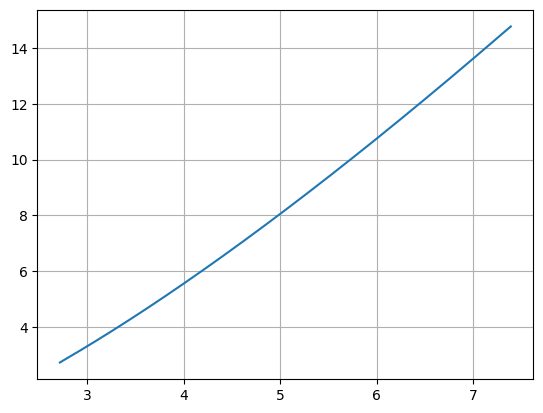

In [10]:
plt.plot(x_grid, y_grid)
plt.grid()

In [11]:
# точки для вывода функции
x_check_base = [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]
i_check_base = 0
x_check = []
y_check = []
for i in range(len(x_grid)):
    if x_check_base[i_check_base] < x_grid[i]:
        x_check.append(x_grid[i])
        y_check.append(y_grid[i])
        i_check_base += 1
    if i_check_base == len(x_check_base):
        break

x_check_method_2 = [i for i in x_check]
y_check_method_2 = [i for i in y_check]
pd.DataFrame({"x": x_check_method_2, "y": y_check_method_2})

,x,y
0,3.003199,3.305113
1,3.502972,4.394301
2,4.002745,5.554969
3,4.502518,6.778155
4,5.002290,8.056933
5,5.502063,9.385694
6,6.001836,10.759842
7,6.501609,12.175690
8,7.001382,13.630009


т.к. все значения $h < 0$ (смотри ниже), то выполнено условие устойчивости метода прогонки


In [12]:
print(min(h_grid[1:-1]), max(h_grid[1:-1]))

-74.13024835527861 -10.074074717915677


### проверка вычисления производных

In [13]:
def y_der1(x):
    return log(x) + 1

def y_der2(x):
    return 1 / x

def y_der1_vec(x_arr):
    N = len(x_arr)
    ret = [None] * N
    for i in range(N):
        ret[i] = y_der1(x_arr[i])
    return ret

def y_der2_vec(x_arr):
    N = len(x_arr)
    ret = [None] * N
    for i in range(N):
        ret[i] = y_der2(x_arr[i])
    return ret

In [14]:
# print(tau)
# pd.DataFrame({"x": x_grid, "y_0": y_0_grid, "y_der1_num": y_0_der1_grid, "y_der1": y_der1_vec(x_grid), "y_der_2_num": y_0_der2_grid, "y_der2": y_der2_vec(x_grid)})

## Сравение результатов 

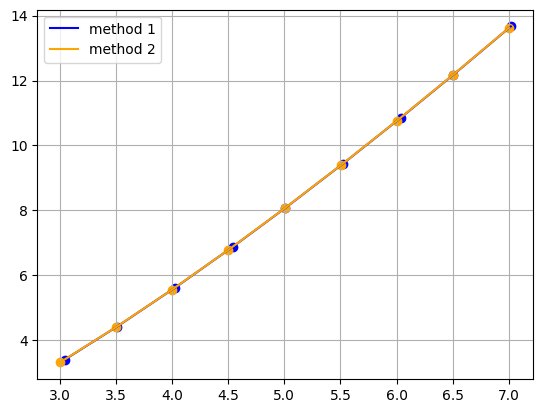

In [15]:
plt.plot(x_check_method_1, y_check_method_1, c="blue", label="method 1")
plt.plot(x_check_method_2, y_check_method_2, c="orange", label="method 2")
plt.scatter(x_check_method_1, y_check_method_1, c="blue")
plt.scatter(x_check_method_2, y_check_method_2, c="orange")
plt.grid()
plt.legend()

In [16]:
pd.DataFrame({"x(1)": x_check_method_1, "y(1)": y_check_method_1, "x(2)": x_check_method_2, "y(2)": y_check_method_2})

,x(1),y(1),x(2),y(2)
0,3.045236,3.391208,3.003199,3.305113
1,3.512313,4.412537,3.502972,4.394301
2,4.026099,5.607653,4.002745,5.554969
3,4.539884,6.868514,4.502518,6.778155
4,5.006961,8.065481,5.002290,8.056933
5,5.520746,9.432394,5.502063,9.385694
6,6.034532,10.847190,6.001836,10.759842
7,6.501609,12.171469,6.501609,12.175690
8,7.015394,13.666875,7.001382,13.630009
